# Homework 2

## FINM 25000 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

## HBS Case

### *ProShares Hedge Replication ETF*

***

In [1]:
%pip install pandas numpy openpyxl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

Note: you may need to restart the kernel to use updated packages.


# 1. The ProShares ETF Product

**Section 1 is not graded**, and you do not need to submit your answers. But you are encouraged to think about them, and we will discuss them.

## 1. Alternative ETFs

Describe the two types of investments referenced by this term.

## 2. Hedge Funds.


* a. Using just the information in the case, what are two measures by which hedge funds are an attractive investment?


* b. What are the main benefits of investing in hedge funds via an ETF instead of directly?

## 3. The Benchmarks

* a. Explain as simply as possible how HFRI, MLFM, MLFM-ES, and HDG differ in their construction and purpose.


* b. How well does the Merrill Lynch Factor Model (MLFM) track the HFRI?

* c. In which factor does the MLFM have the largest loading? (See a slide in Exhibit 1.)


* d. What are the main concerns you have for how the MLFM attempts to replicate the HFRI?


## 4. The HDG Product

* a. What does ProShares ETF, HDG, attempt to track? Is the tracking error small?

* b. HDG is, by construction, delivering beta for investors. Isn't the point of hedge funds to generate alpha? Then why would HDG be valuable?

* c. The fees of a typical hedge-fund are 2% on total assets plus 20% of excess returns if positive. HDG's expense ratio is roughly 1% on total assets. What would their respective net Sharpe Ratios be, assuming both have a gross excess returns of 10% and volatility of 20%?

In [16]:
sharpe_ratio = ((1 - 0.02) * (1 - 0.2) * (1 - 0.01) * 0.1) / 0.2

print(f" The sharpe ratio would be: {sharpe_ratio:.2f}")

 The sharpe ratio would be: 0.39


***

# 2.  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `May 2025`.

In [5]:
#FINM250-Quant-2025 dataframe
import pandas as pd
import numpy as np
import os

# Load the hedge fund series data from the Excel file
hedge_fund_series_df_2024 = pd.read_excel(io='proshares_analysis_data.xlsx',
    sheet_name='hedge_fund_series',
    index_col=0,
    parse_dates=[0])

display(hedge_fund_series_df_2024.head())

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027035,-0.006491
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2011-10-31,0.026858,0.043593,0.043320,0.050532,0.025241
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001854


## 1. 

For the series in the "hedge fund series" tab, report the following summary statistics:
* mean
* volatility
* Sharpe ratio

Annualize these statistics.

In [6]:
#Functions from HW1

def metrics(returns_df):
  return_metrics = pd.DataFrame()

  adjustment_factor = 12

  return_metrics['Annualized Mean'] = returns_df.mean() * adjustment_factor
  return_metrics['Annualized Volatility'] = returns_df.std() * np.sqrt(adjustment_factor)
  return_metrics['Annualized Sharpe Ratio'] = return_metrics['Annualized Mean'] / return_metrics['Annualized Volatility']
  return return_metrics.T

display(metrics(hedge_fund_series_df_2024))

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Annualized Mean,0.041447,0.030670,0.029239,0.019442,0.016958
Annualized Volatility,0.060416,0.057147,0.056985,0.059589,0.049895
Annualized Sharpe Ratio,0.686023,0.536686,0.513102,0.326268,0.339873


## 2.

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk.
* Skewness
* Excess Kurtosis (in excess of 3)
* VaR (.05) - the fifth quantile of historic returns
* CVaR (.05) - the mean of the returns at or below the fifth quantile
* Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [5]:
# Calculate and display tail-risk statistics for all series, referenced from 2024 solution
def calc_risk_metrics(data, as_df=False, adj=12):
    """
    Calculate risk metrics for a given dataset. Specifically:
    - Skewness
    - Kurt
    - VaR (0.05)
    - CVaR (0.05)
    - Max Return in a single period
    - Min Return in a single period
    - Peak
    - Max Drawdown
    - Bottom (of drawdown)
    - Recovery (of drawdown)

    Args:
        data : Returns time series.
        as_df (bool, optional): Return a df or a dictionary. Defaults to False.
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        DataFrame or Dictionary: Summary of risk metrics.
    """
    summary = dict()
    summary["Skewness"] = data.skew()
    summary["Excess Kurtosis"] = data.kurtosis()
    summary["VaR (0.05)"] = data.quantile(0.05, axis=0)
    summary["CVaR (0.05)"] = data[data <= data.quantile(0.05, axis=0)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    # Cumulative returns on $1000
    wealth_index = 1000 * (1 + data).cumprod()

    previous_peaks = wealth_index.cummax()

    # Biggest difference between cumulative max and your current wealth
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    summary["Peak"] = previous_peaks.idxmax()
    summary["Bottom"] = drawdowns.idxmin()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )

    # Here, we use a list comprehension to check if the recovery date is null,
    # meaning that the drawdown has not yet recovered.
    summary["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

    # Note that here we use the zip() function to iterator over two lists at the same time.
    # This is equivalent to using a for loop over the indices of the lists, and then getting
    # the values at those indices.
    summary["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(summary["Recovery"], summary["Bottom"])
    ]

    return pd.DataFrame(summary, index=data.columns) if as_df else summary

# Calculate and display tail-risk statistics for all series
risk_metrics = calc_risk_metrics(hedge_fund_series_df_2024, as_df=True)
display(risk_metrics[["Skewness", "Excess Kurtosis", "VaR (0.05)", "CVaR (0.05)", "Max Drawdown", "Peak", "Bottom", "Recovery"]])

,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Max Drawdown,Peak,Bottom,Recovery
HFRIFWI Index,-0.979063,5.955123,-0.025324,-0.037478,-0.115473,2021-10-31,2020-03-31,2020-08-31 00:00:00
MLEIFCTR Index,-0.244981,1.689648,-0.028764,-0.035857,-0.124302,2021-06-30,2022-09-30,-
MLEIFCTX Index,-0.231032,1.657903,-0.029119,-0.035816,-0.124388,2021-06-30,2022-09-30,-
HDG US Equity,-0.233880,1.799098,-0.031209,-0.037577,-0.140721,2021-06-30,2022-09-30,-
QAI US Equity,-0.461338,1.825993,-0.020593,-0.032695,-0.137712,2021-06-30,2022-09-30,-


## 3. 

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:
* Market Beta
* Treynor Ratio
* Information ratio

Annualize these three statistics as appropriate.

In [8]:
merrill_factors_df_2024 = pd.read_excel(io='proshares_analysis_data.xlsx',
    sheet_name='merrill_factors',
    index_col=0,
    parse_dates=[0])

merrill_factors_df_2024.head(5)

,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
2011-08-31,-0.054976,0.000009,-0.092549,-0.087549,-0.005889,-0.088913
2011-09-30,-0.069449,0.000017,-0.179064,-0.108083,0.142180,-0.111541
2011-10-31,0.109147,-0.000013,0.162986,0.096275,-0.069502,0.151012
2011-11-30,-0.004064,0.000000,-0.019723,-0.021764,0.054627,-0.003783
2011-12-31,0.010440,0.000009,-0.043017,-0.022139,0.075581,0.005114


In [15]:
def calc_univ_regr(y, X, intercept=True, adj=12):
    """
    Calculate a univariate regression of y on X. Note that both X and y
    need to be one-dimensional.

    Args:
        y : target variable
        X : independent variable
        intercept (bool, optional): Fit the regression with an intercept or not. Defaults to True.
        adj (int, optional): What to adjust the returns by. Defaults to 12.

    Returns:
        DataFrame: Summary of regression results
    """
    X_down = X[X < 0]
    y_down = y[X < 0]
    if intercept:
        X = sm.add_constant(X)
        X_down = sm.add_constant(X_down)

    model = sm.OLS(y, X, missing="drop")
    results = model.fit()

    # Use label-based access for params
    if intercept:
        inter = results.params['const'] if 'const' in results.params else 0
        beta = results.params[X.columns[1]] if hasattr(X, 'columns') and len(X.columns) > 1 else results.params[X.name]
    else:
        inter = 0
        beta = results.params[X.name] if X.name in results.params else results.params[0]

    summary = dict()

    summary["Alpha"] = inter * adj
    summary["Beta"] = beta

    # Downside Beta
    if intercept:
        down_mod = sm.OLS(y_down, X_down, missing="drop").fit()
        if 'const' in down_mod.params:
            summary["Downside Beta"] = down_mod.params[X_down.columns[1]] if hasattr(X_down, 'columns') and len(X_down.columns) > 1 else down_mod.params[X_down.columns[-1]]
        else:
            summary["Downside Beta"] = down_mod.params[X_down.columns[-1]]
    else:
        down_mod = sm.OLS(y_down, X_down, missing="drop").fit()
        summary["Downside Beta"] = down_mod.params[X_down.name] if X_down.name in down_mod.params else down_mod.params[0]

    summary["R-Squared"] = results.rsquared
    summary["Treynor Ratio"] = (y.mean() / beta) * adj
    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(adj)
    summary["Tracking Error"] = (
        inter / summary["Information Ratio"]
        if intercept
        else results.resid.std() * np.sqrt(adj)
    )

    return pd.DataFrame(summary, index=[y.name])

# For each hedge fund series, regress against SPY US Equity and collect the results
regression_results = []
for col in hedge_fund_series_df_2024.columns:
    y = hedge_fund_series_df_2024[col].dropna()
    X = merrill_factors_df_2024.loc[y.index, "SPY US Equity"].dropna()
    # Align y and X
    y, X = y.align(X, join='inner')
    reg_result = calc_univ_regr(y, X)
    reg_result.index = [col]
    regression_results.append(reg_result)
regression_summary = pd.concat(regression_results)
display(regression_summary[["Beta", "Treynor Ratio", "Information Ratio"]])

,Beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.348217,0.119027,-0.109520
MLEIFCTR Index,0.349859,0.087664,-0.571877
MLEIFCTX Index,0.348514,0.083896,-0.620547
HDG US Equity,0.359536,0.054075,-0.964387
QAI US Equity,0.294096,0.057662,-0.832728


## 4. 

Discuss the previous statistics, and what they tell us about...

* the differences between SPY and the hedge-fund series?
* which performs better between HDG and QAI.
* whether HDG and the ML series capture the most notable properties of HFRI.

## Response to Q4:

For all four funds, the beta values indicate they are less volatile than SPY. The Treynor Ratio shows that their returns relative to market risk are low, suggesting they may be taking on more market risk than is warranted by their returns. The Information Ratio further suggests limited manager skill.

Comparing HDG and QAI, QAI stands out as the better performer due to its lower volatility, higher return per unit of market risk, and a slightly higher Information Ratio, indicating marginally better skill.

## 5. 

Report the correlation matrix for these assets.
* Show the correlations as a heat map.
* Which series have the highest and lowest correlations?

<Axes: >

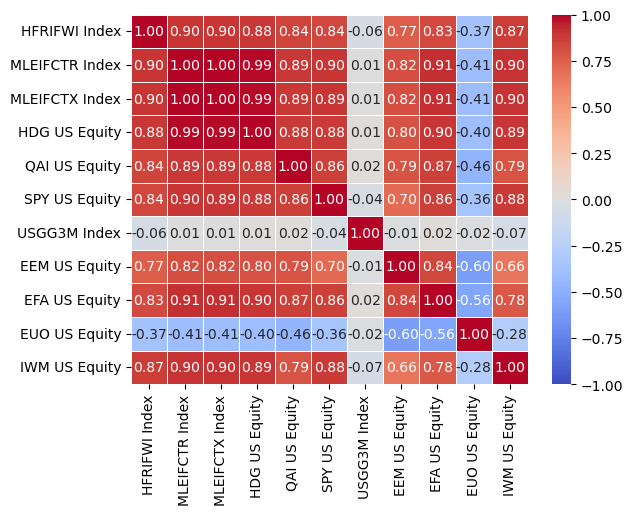

In [ ]:
# Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_corr_matrix(corrs):
    # Correlation helper function.
    return sns.heatmap(
        corrs,
        annot=True,
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        linewidths=0.7,
        annot_kws={"size": 10},
        fmt=".2f",
        square=True,
        cbar_kws={"shrink": 0.75},
    )

# Load the hedge fund series and Merrill factors data   

hedge_fund_series_df_2024 = pd.read_excel(io='proshares_analysis_data.xlsx',
    sheet_name='hedge_fund_series',
    index_col=0,
    parse_dates=[0])

merrill_factors_df_2024 = pd.read_excel(io='proshares_analysis_data.xlsx',
    sheet_name='merrill_factors',
    index_col=0,
    parse_dates=[0])

corr_matrix = pd.concat([hedge_fund_series_df_2024,  merrill_factors_df_2024], axis=1).corr()

sns.heatmap(corr_matrix,
            cmap="coolwarm",
            annot=True,
            vmin = -1,
            vmax = 1,
            linewidths=0.7,
            fmt = ".2f",
            )

## 6.

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,

$\newcommand{\hfri}{\text{hfri}}$
$\newcommand{\merr}{\text{merr}}$

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\hat{r}^{\hfri}_{t} &= \hat{\alpha}^{\merr} + x_{t}^{\merr}\hat{\beta}^{\merr}
\end{align}$$

Note that the second equation is just our notation for the fitted replication.

a. Report the intercept and betas.

b. Are the betas realistic position sizes, or do they require huge long-short positions?

c. Report the R-squared.

d. Report the volatility of $\epsilon^{\merr}$, the tracking error.

In [30]:
def multivariate_regression(fund, explanatory):
    """
    Function is designed to calculate the multivariate regression of y against X.
    Can also do downside beta (when market < 0) and upside beta (when market > 0)

    Args:
      funds: a dataframe with the target variables
      explanatory: a dataframe with the explanatory variables
    Returns:
        DataFrame: Summary of results
    """
    results = sm.OLS(fund, sm.add_constant(explanatory), missing='drop').fit()
    parameters = results.params
    intercept = parameters.get('const', parameters.iloc[0])
    betas = parameters.drop('const') if 'const' in parameters else parameters.iloc[1:]

    summary = dict()
    summary['Intercept'] = intercept * 12
    summary['R-Squared'] = results.rsquared
    residuals = results.resid
    summary['Tracking Error'] = residuals.std() * np.sqrt(12)

    for col in betas.index:
        summary[f"{col} Beta"] = betas[col]

    return pd.DataFrame(summary, index=[fund.name]).T

multivariate_regression(hedge_fund_series_df_2024['HFRIFWI Index'], merrill_factors_df_2024)

,HFRIFWI Index
Intercept,0.017794
R-Squared,0.836058
Tracking Error,0.024462
SPY US Equity Beta,0.029963
USGG3M Index Beta,-0.370915
EEM US Equity Beta,0.079118
EFA US Equity Beta,0.084161
EUO US Equity Beta,0.023106
IWM US Equity Beta,0.153294


## 7.

Let's examine the replication out-of-sample (OOS).

Starting with $t = 61$ month of the sample, do the following:

* Use the previous 60 months of data to estimate the regression equation. 
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\merr}_{t}$ and $\tilde{\beta}^{\merr}_{t}$.

* Use the estimated regression parameters, along with the time-t regressor values, $x^{\merr}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).

$$\hat{r}^{\hfri}_{t} \equiv \tilde{\alpha}^{\merr} + (x_{t}^{\merr})'\tilde{\beta}^{\merr}$$

* Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

OOS R-Squared: 80.87%


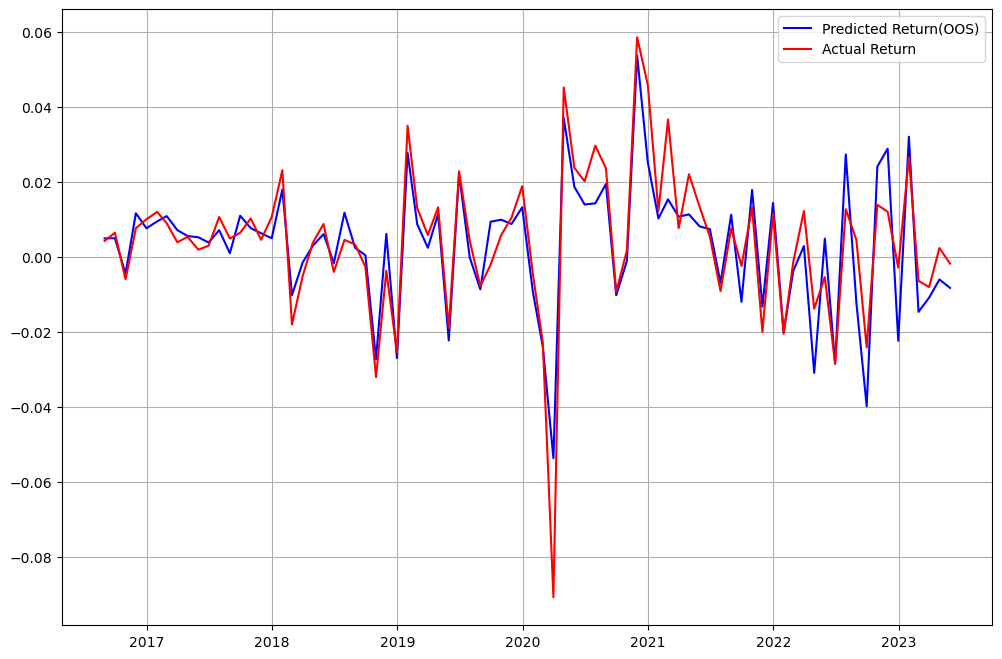

In [35]:
from collections import defaultdict
import matplotlib.pyplot as plt

def oos_rolling_regression(fund, explanatory):
    """
    This function is designed to calculate the out-of-sample rolling regression of fund against explanatory (factors).

    Args:
      fund: a dataframe with the target variables
      explanatory: a dataframe with the explanatory variables (factors)

    Returns:
        DataFrame: Summary of results
    """
    summary = defaultdict(list)
    for t in range(60, len(fund)):
        past_factors = explanatory.iloc[t - 60:t].copy()
        past_fund_rets = fund.iloc[t - 60:t].copy()
        oos_y = fund.iloc[t].copy()
        oos_x = explanatory.iloc[t].copy()
        model = sm.OLS(past_fund_rets, sm.add_constant(past_factors), missing='drop').fit()
        # Use label-based access for params
        for param in model.params.index:
            summary[param].append(model.params[param])
        intercept = model.params.get('const', model.params.iloc[0])
        betas = model.params.drop('const') if 'const' in model.params else model.params.iloc[1:]
        prediction = intercept + betas.values @ oos_x.values
        summary['Predicted Return(OOS)'].append(prediction)
        summary['Actual Return'].append(oos_y)
    summary = pd.DataFrame(summary, index=fund.index[60:])
    return summary

# the rolling regression for this problem
rolling_regr = oos_rolling_regression(hedge_fund_series_df_2024['HFRIFWI Index'], merrill_factors_df_2024)

# r-squared calculation given the built in correlation function in python
r_squared = rolling_regr['Predicted Return(OOS)'].corr(rolling_regr['Actual Return'])**2


#displaying statistics
print(f'OOS R-Squared: {r_squared:.2%}')

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(rolling_regr['Predicted Return(OOS)'], label = 'Predicted Return(OOS)', color = 'blue')
ax.plot(rolling_regr['Actual Return'], label = 'Actual Return', color = 'red')
ax.grid(True)
ax.legend();

***

# 3.  Extensions
<i>**This section is not graded, and you do not need to submit it.** Still, we may discuss it in class some extensions in class.

For those looking for a challenge, try a few of these.

## 1. 

Merrill constrains the weights of each asset in its replication regression of HFRI. Try constraining your weights by re-doing 2.6.

* Use Non-Negative Least Squares (NNLS) instead of OLS.
* Go further by using a Generalized Linear Model to put separate interval constraints on each beta, rather than simply constraining them to be non-negative.

#### Hints
* Try using LinearRegression in scikit-learn with the parameter `positive=True`. 
* Try using GLM in statsmodels.

## 2. 

Let's decompose a few other targets to see if they behave as their name suggests.

* Regress HEFA on the same style factors used to decompose HFRI. Does HEFA appear to be a currency-hedged version of EFA?

* Decompose TRVCI with the same style factors used to decompose HFRI. The TRVCI Index tracks venture capital funds--in terms of our styles, what best describes venture capital?

* TAIL is an ETF that tracks SPY, but that also buys put options to protect against market downturns. Calculate the statistics in questions 2.1-2.3 for TAIL. Does it seem to behave as indicated by this description? That is, does it have high correlation to SPY while delivering lower tail risk?

## 3. 

The ProShares case introduces Levered ETFs. ProShares made much of its name originally through levered, or "geared" ETFs.

Explain conceptually why Levered ETFs may track their index well for a given day but diverge over time. How is this exacerbated in volatile periods like 2008?

## 4.

Analyze SPXU and UPRO relative to SPY.
- SPXU is ProShares -3x SPX ETF.
- UPRO is ProShres +3x SPX ETF.

Questions:
* Analyze them with the statistics from 2.1-2.3. 

* Do these two ETFs seem to live up to their names?

* Plot the cumulative returns of both these ETFs along with SPY.

* What do you conclude about levered ETFs?

## 5.

In `Section 2`, we estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{align}
r^{\hfri}_{t} &= \alpha^{\merr} + x_{t}^{\merr}\beta^{\merr} + \epsilon_{t}^{\merr}\\[5pt]
\check{r}^{\hfri}_{t} &= \check{\alpha}^{\merr} + x_{t}^{\merr}\check{\beta}^{\merr}
\end{align}$$

Report

* the regression beta. How does it compare to the estimated beta with an intercept, $\hat{\beta}^{\merr}$?

* the mean of the fitted value, $\check{r}^{\hfri}_{t}$. How does it compare to the mean of the HFRI?

* the correlations of the fitted values, $\check{r}^{\hfri}_{t}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\hat{r}^{\hfri}_{t}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?